In [1]:
import pandas as pd
df = pd.read_csv(r"C:\Users\km_ka\Desktop\Demo\Dataset\dataset.csv")
df.head()


Minute   Root Detector ID  Sedan Count  Vans Count  SUV Count  \
0       0  42428287_42430333         20.0         7.0        1.0   
1       0  42430333_42428287         20.0         7.0        1.0   
2       0  42430358_42430361         17.0         3.0        0.0   
3       0  42430361_42440004         30.0         5.0        3.0   
4       0  42430371_42450426          3.0         0.0        0.0   

   Heavy_Truck Count  Total Average Speed (km/h)  Total Emissions (g)  
0                4.0                   22.348040          5173.423194  
1                4.0                   22.062504          5173.423194  
2                3.0                   14.897145          3142.154765  
3                8.0                   28.798213          8180.338235  
4                0.0                   13.202643           422.809771

In [2]:
import folium
import pickle
import pandas as pd

# ✅ Load road geometry once
with open(r"C:\Users\km_ka\Desktop\Demo\Dataset\Meta_Data\G_custom.pkl", "rb") as f:
    G = pickle.load(f)  # important for cross-OS pickles

    
with open(r"C:\Users\km_ka\Desktop\Demo\Dataset\Meta_Data\line_graph.pkl", "rb") as f:
    L = pickle.load(f)

line_nodes = list(L.nodes)

In [3]:

# Prepare a list of edges with coordinates
road_segments = []
for (u, v) in line_nodes:  # your existing list of edges
    x1, y1 = G.nodes[u]['x'], G.nodes[u]['y']
    x2, y2 = G.nodes[v]['x'], G.nodes[v]['y']
    road_segments.append({
        "edge": (u, v),
        "geometry": [(y1, x1), (y2, x2)]
    })

road_df = pd.DataFrame(road_segments)

# ✅ Function to plot original road network
def plot_road_network():
    m = folium.Map(location=[40.7831, -73.9712], zoom_start=13)
    for _, row in road_df.iterrows():
        folium.PolyLine(
            locations=row["geometry"],
            color="blue",  # just a fixed color
            weight=3,
            tooltip=f"Edge: {row['edge']}"
        ).add_to(m)
    return m

# Usage
m = plot_road_network()
m


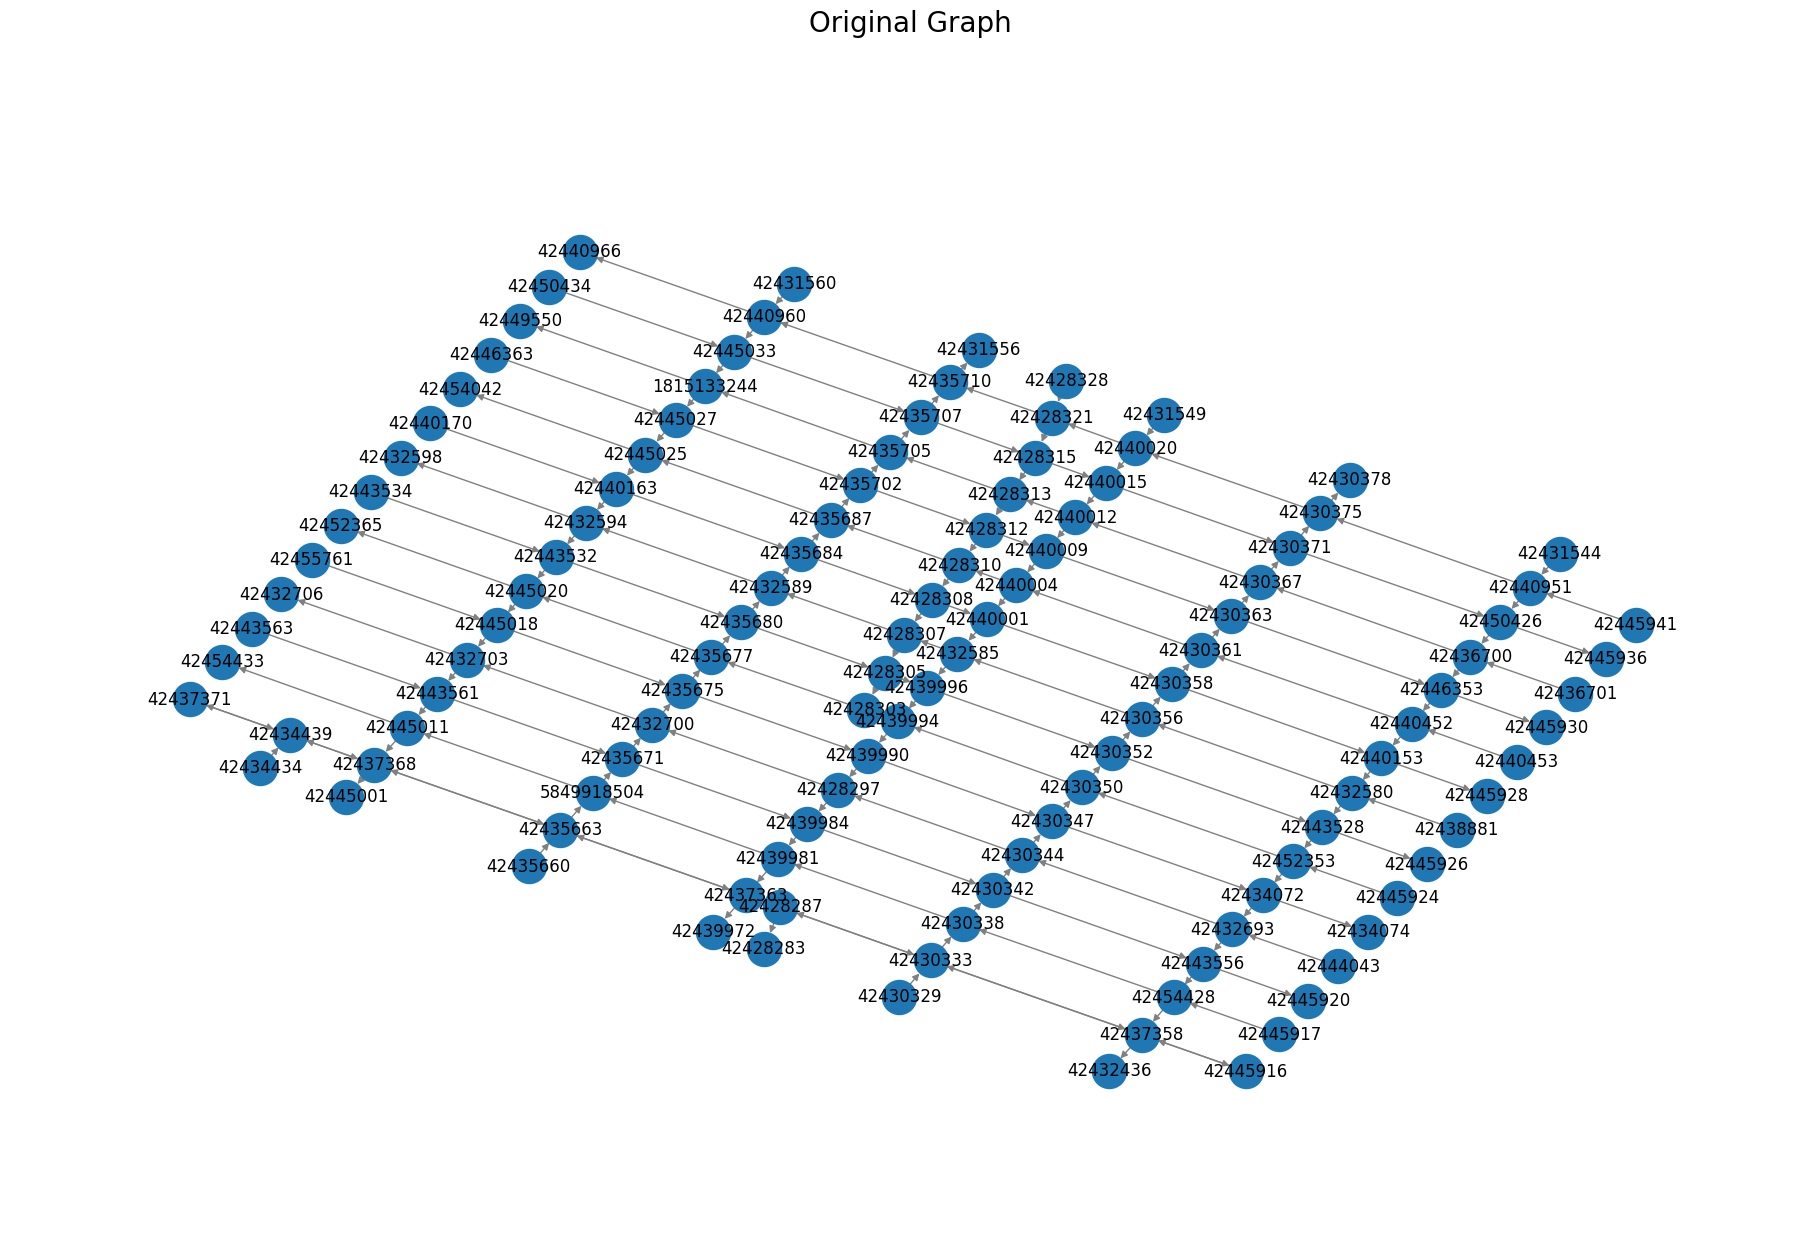

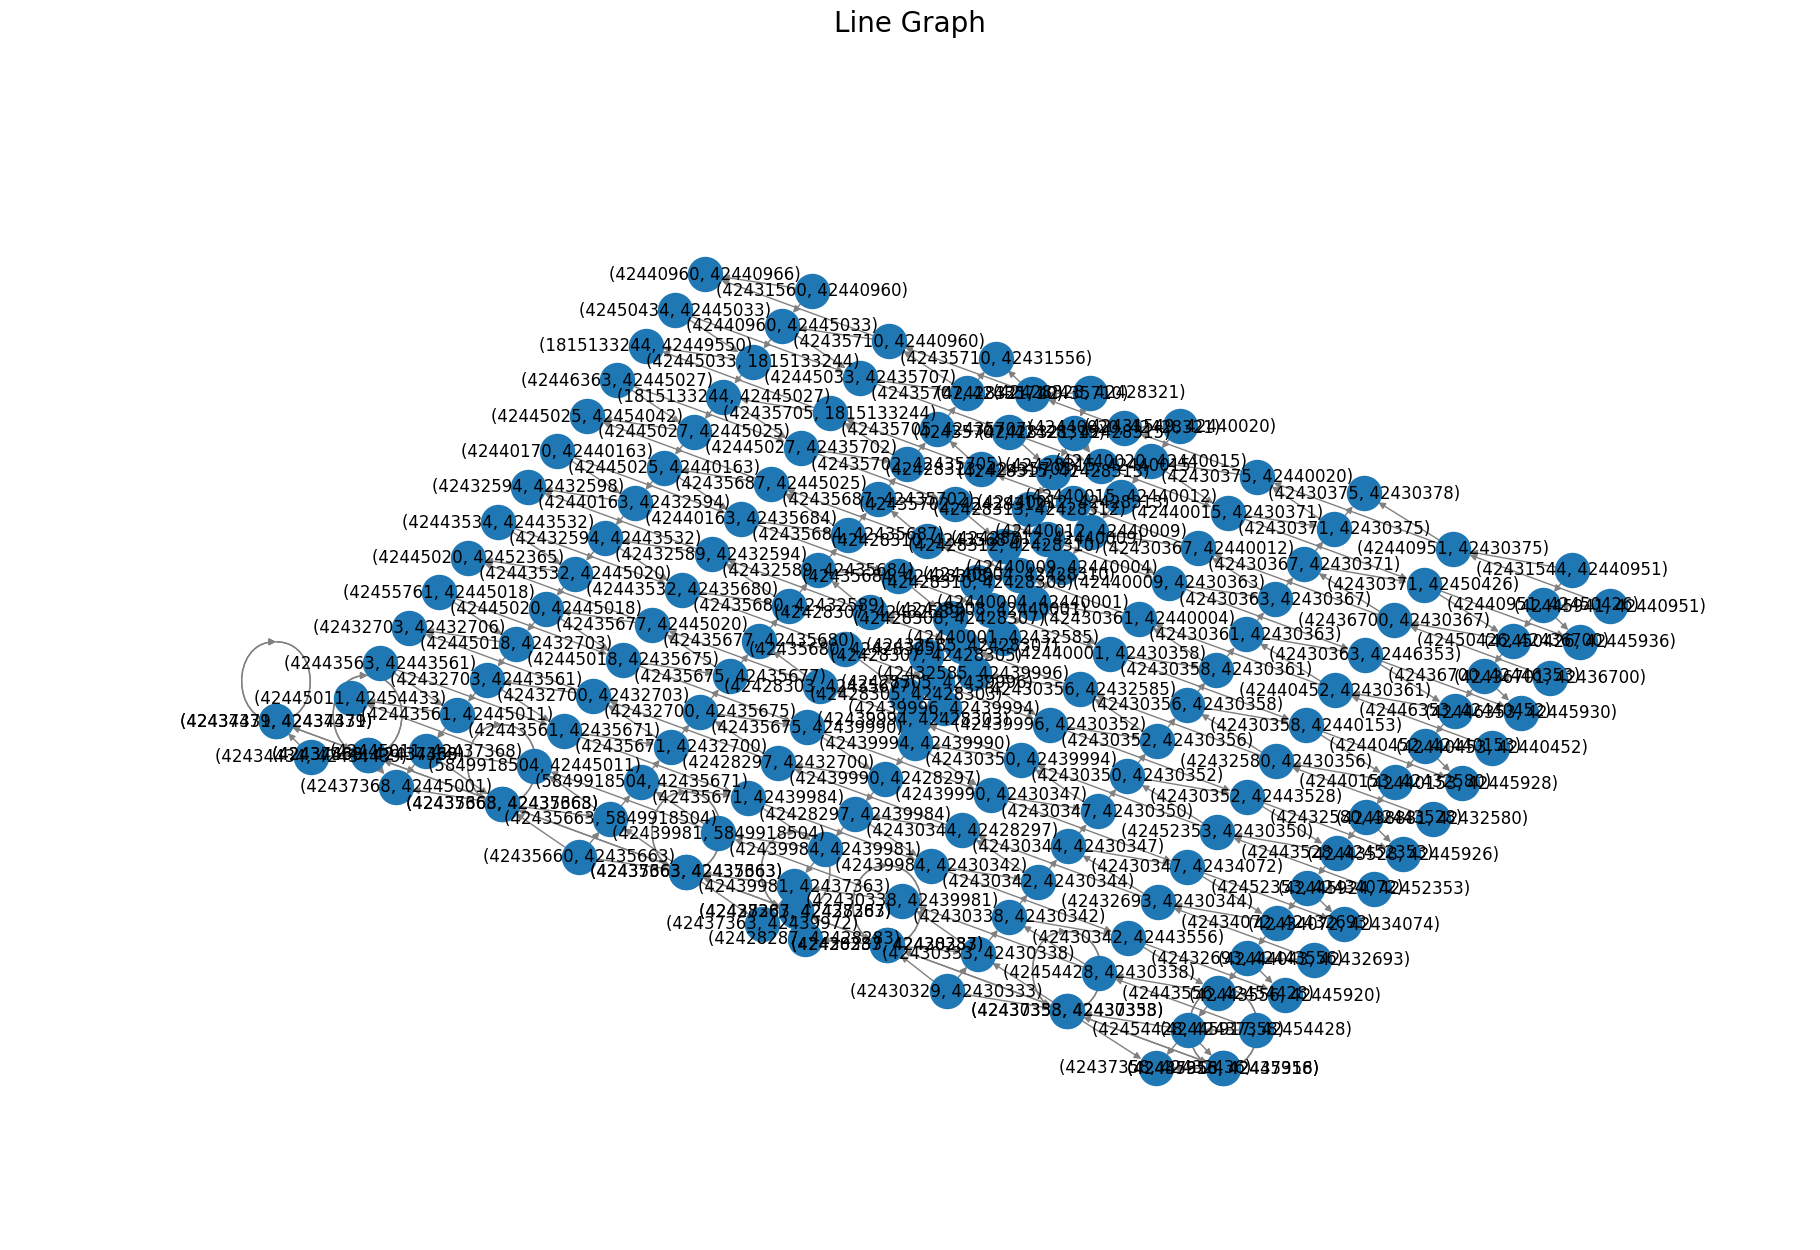

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph_and_line_graph(G_custom):
    """
    Visualizes the original graph and its line graph in larger figures.
    
    Parameters:
        G_custom: networkx.Graph
            The original road network graph with 'x', 'y' node attributes.
    """
    # ------------------- Original Graph -------------------
    positions = {node: (G_custom.nodes[node]['x'], G_custom.nodes[node]['y']) for node in G_custom.nodes()}

    plt.figure(figsize=(18, 12))  # Bigger figure
    nx.draw(
        G_custom, 
        pos=positions, 
        with_labels=True, 
        node_size=600,   # bigger nodes
        font_size=12,    # bigger labels
        edge_color='gray', 
        arrows=True
    )
    plt.title("Original Graph", fontsize=20)
    plt.show()
    
    # ------------------- Line Graph -------------------
    L = nx.line_graph(G_custom)

    line_graph_positions = {}
    for u, v in L.nodes():
        x1, y1 = G_custom.nodes[u]['x'], G_custom.nodes[u]['y']
        x2, y2 = G_custom.nodes[v]['x'], G_custom.nodes[v]['y']
        line_graph_positions[(u, v)] = ((x1 + x2) / 2, (y1 + y2) / 2)

    plt.figure(figsize=(18, 12))  # Bigger figure
    nx.draw(
        L, 
        pos=line_graph_positions, 
        with_labels=True, 
        node_size=600,   # bigger nodes
        font_size=12,    # bigger labels
        edge_color='gray', 
        arrows=True
    )
    plt.title("Line Graph", fontsize=20)
    plt.show()

# Usage
visualize_graph_and_line_graph(G)



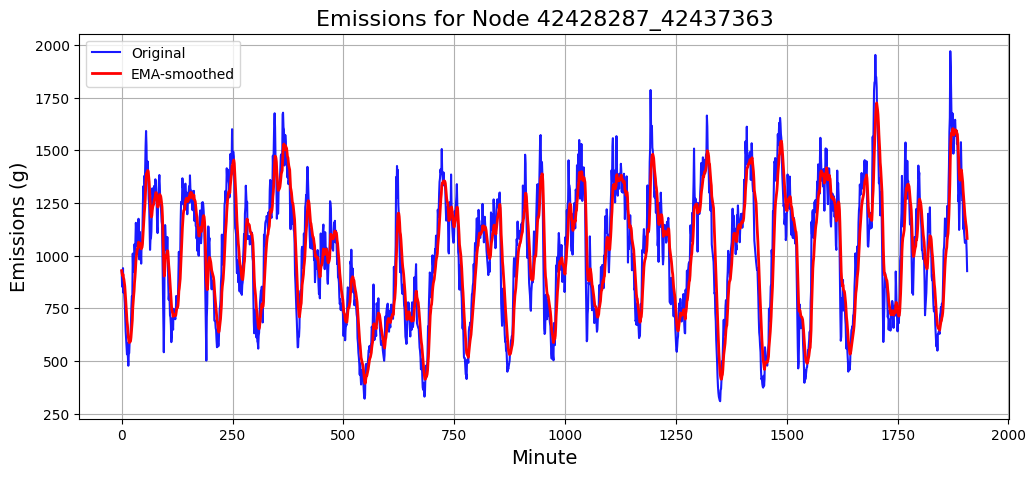

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv(r"C:\Users\km_ka\Desktop\Demo\Dataset\Meta_Data\datasets.csv")

# Sort by detector and time
df = df.sort_values(['Root Detector ID', 'Minute'])

# Feature to smooth
feature = 'Total Emissions (g)'

# Compute EMA for emissions
df[feature + '_EMA'] = df.groupby('Root Detector ID')[feature] \
                          .transform(lambda x: x.ewm(span=10, adjust=False).mean())

# Select a specific node
node = df['Root Detector ID'].unique()[4]  # change index as needed
sub = df[df['Root Detector ID'] == node]

# Plot
plt.figure(figsize=(12,5))
plt.plot(sub['Minute'], sub[feature], alpha=0.9, label='Original', color='blue')
plt.plot(sub['Minute'], sub[feature + '_EMA'], color='red', label='EMA-smoothed', linewidth=2)
plt.title(f"Emissions for Node {node}", fontsize=16)
plt.xlabel("Minute", fontsize=14)
plt.ylabel("Emissions (g)", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()



In [6]:
import sys
import importlib
sys.path.append(r"C:\Users\km_ka\Desktop\Demo\utils")  
import data_utils
importlib.reload(data_utils) 

<module 'data_utils' from 'C:\\Users\\km_ka\\Desktop\\Demo\\utils\\data_utils.py'>

In [7]:
train_df, test_df = data_utils.split_train_test(df, time_col="Minute", train_ratio=0.8)
normalized_train_df, normalized_test_df, scaler = data_utils.normalize_features(train_df, test_df, cols_to_normalize=['Sedan Count', 'Vans Count', 'SUV Count', 'Heavy_Truck Count','Total Average Speed (km/h)','Total Emissions (g)' ])

✅ Train set: 0 → 1528 (1510 unique Minutes)
✅ Test set: 1529 → 1907 (377 unique Minutes)
✅ Normalization complete. Returning scaled dataframes and scaler.


In [8]:
X,adj_matrix,node_to_idx,timesteps = data_utils.build_tensors(normalized_train_df, L, features=['Sedan Count', 'Vans Count', 'SUV Count', 'Heavy_Truck Count','Total Average Speed (km/h)','Total Emissions (g)'])

In [9]:
X_test,adj_matrix_test,node_to_idx_test,timesteps_test = data_utils.build_tensors(normalized_test_df, L, features=['Sedan Count', 'Vans Count', 'SUV Count', 'Heavy_Truck Count','Total Average Speed (km/h)','Total Emissions (g)'])

In [10]:
import training_utils
importlib.reload(training_utils) 

<module 'training_utils' from 'C:\\Users\\km_ka\\Desktop\\Demo\\utils\\training_utils.py'>

In [11]:
checkpoint_path=r"C:\Users\km_ka\Desktop\Demo\Checkpoints\injected_model.pth"
checkpoint, missing_indexes, node_mask, last_P = training_utils.load_trained_model(checkpoint_path)

✅ Checkpoint loaded successfully from C:\Users\km_ka\Desktop\Demo\Checkpoints\injected_model.pth


In [12]:
X_masked=training_utils.apply_node_mask(X, node_mask)

In [13]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
sys.path.append(r"C:\Users\km_ka\Desktop\Demo\Model")  
import model
importlib.reload(model) 
from config import config
seq_len = config.training.seq_len
pred_len = config.training.pred_len
batch_size = config.training.batch_sz
epochs = config.training.epochs
learning_rate = config.training.lr
epsilon = config.training.eps
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_seq, Y_seq= data_utils.create_sequences(X_masked,seq_len,pred_len)
dataset = TensorDataset(X_seq, Y_seq)
loader  = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# ─────────────── model & optimiser ─────────
modele = model.SpatioTemporalAttentionDiffusionNet(
            in_features=X.shape[-1],
            hidden_dim=config.model.hidden_dim,
            forecast_len=pred_len,
            sequence_len=seq_len,
            num_nodes=X.shape[1],
            prejection=config.model.prejection,
            k_hop=config.model.k_hops,

        ).to(device)



In [14]:
modele.load_state_dict(checkpoint["model_state"])

<All keys matched successfully>

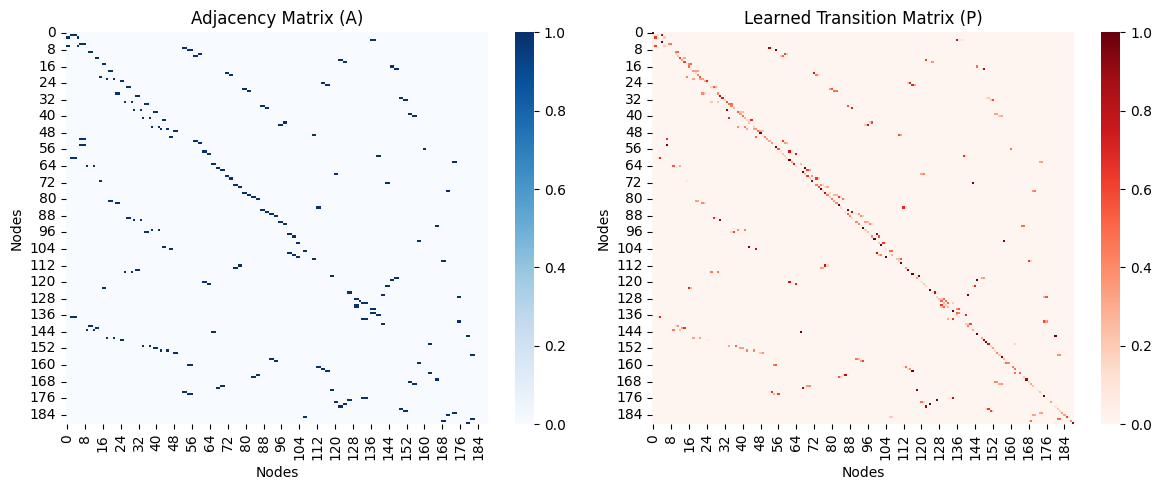

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

# Load adjacency matrix (A)
A = adj_matrix

# Load last learned transition matrix (P)
P = last_P
if isinstance(P, torch.Tensor):
    P = P.cpu().numpy()

# Select the last time step / epoch
P = P[-1]  # shape (189, 189)

# Use the same color range for fair comparison
vmax = max(A.max(), P.max())
vmin = min(A.min(), P.min())

# Set up subplot grid
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot adjacency matrix heatmap
sns.heatmap(A, cmap="Blues", cbar=True, ax=axes[0], vmin=vmin, vmax=vmax)
axes[0].set_title("Adjacency Matrix (A)")
axes[0].set_xlabel("Nodes")
axes[0].set_ylabel("Nodes")

# Plot learned transition matrix heatmap
sns.heatmap(P, cmap="Reds", cbar=True, ax=axes[1], vmin=vmin, vmax=vmax)
axes[1].set_title("Learned Transition Matrix (P)")
axes[1].set_xlabel("Nodes")
axes[1].set_ylabel("Nodes")

plt.tight_layout()
plt.show()

Test Results for Imputation

In [16]:
import vis_utils
importlib.reload(vis_utils) 

<module 'vis_utils' from 'C:\\Users\\km_ka\\Desktop\\Demo\\utils\\vis_utils.py'>

In [17]:
loss_fn = nn.MSELoss(reduction="none")
results = training_utils.run_imputation_inference(
    model=modele,
    X=X,
    seq_len=seq_len,
    pred_len=pred_len,
    node_mask=node_mask,
    adj_matrix=adj_matrix,
    batch_size=batch_size,
    device=device,
    loss_fn=loss_fn
)

✅ Imputation Loss: 0.01768


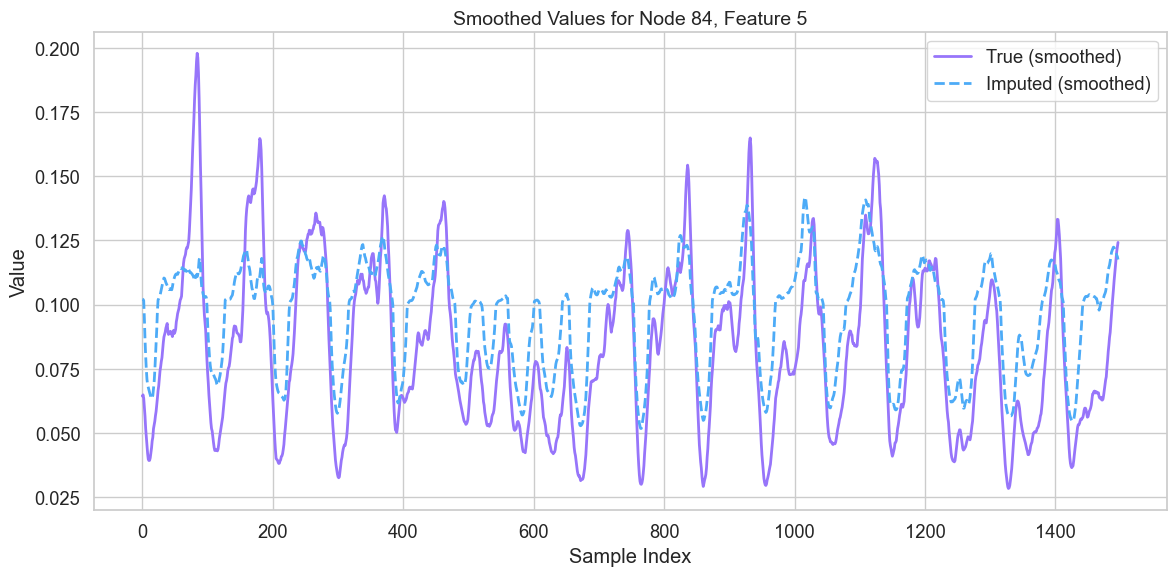

In [18]:
true_vals = results["true_inputs"]      
imputed_vals = results["imputations"]   
# Plot for a specific node and feature
node_idx = 84 # first node
feature_idx = 5   # feature index you want to plot

vis_utils.plot_smoothed_node_series(true_vals, imputed_vals, node_idx=node_idx, feature_idx=feature_idx)


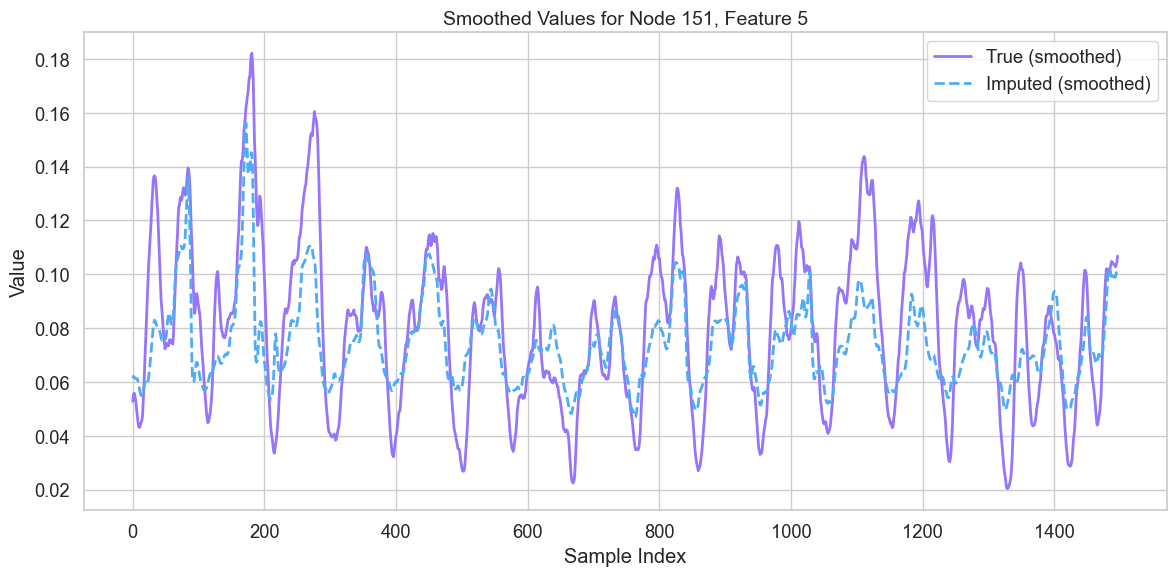

In [19]:
true_vals = results["true_inputs"]      
imputed_vals = results["imputations"]   
# Plot for a specific node and feature
node_idx = 151 # first node
feature_idx = 5   # feature index you want to plot

vis_utils.plot_smoothed_node_series(true_vals, imputed_vals, node_idx=node_idx, feature_idx=feature_idx)


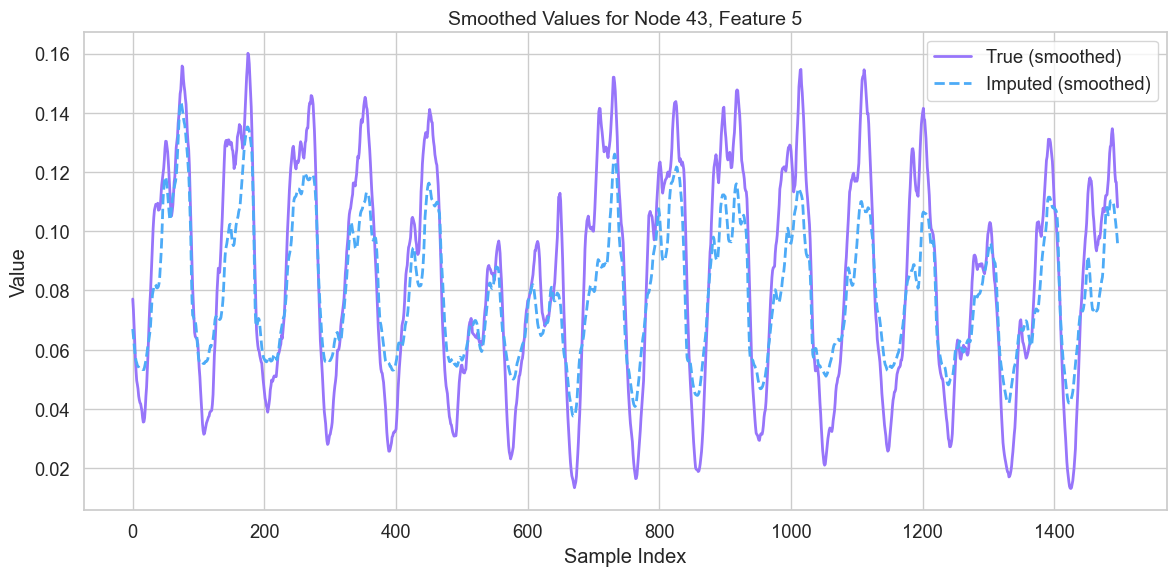

In [20]:
true_vals = results["true_inputs"]      
imputed_vals = results["imputations"]   
# Plot for a specific node and feature
node_idx = 43 # first node
feature_idx = 5   # feature index you want to plot

vis_utils.plot_smoothed_node_series(true_vals, imputed_vals, node_idx=node_idx, feature_idx=feature_idx)


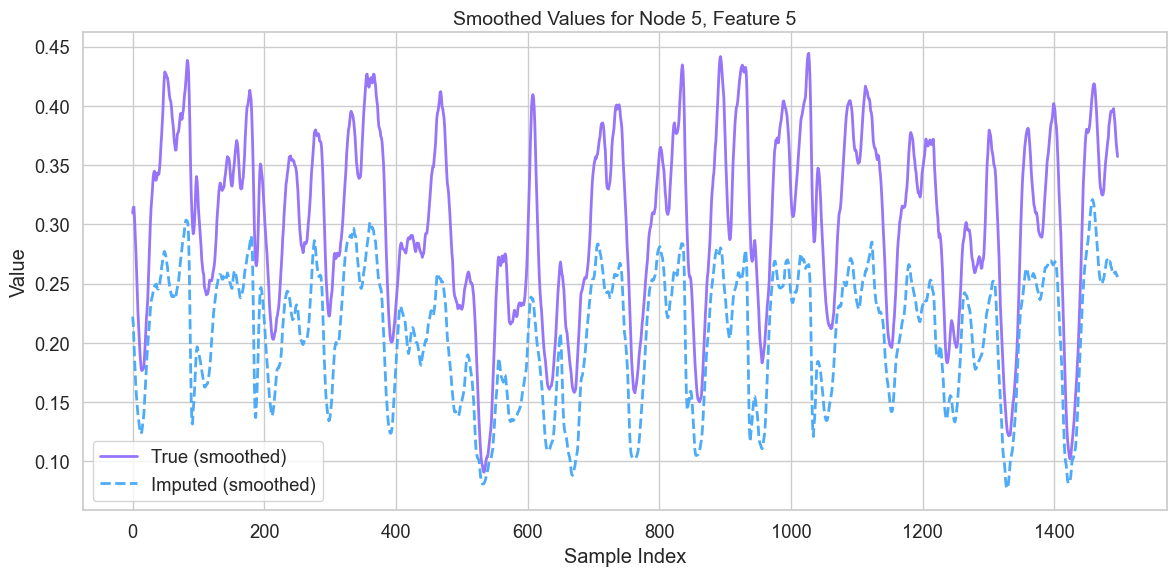

In [21]:
true_vals = results["true_inputs"]      
imputed_vals = results["imputations"]   
# Plot for a specific node and feature
node_idx = 5 # first node
feature_idx = 5   # feature index you want to plot

vis_utils.plot_smoothed_node_series(true_vals, imputed_vals, node_idx=node_idx, feature_idx=feature_idx)


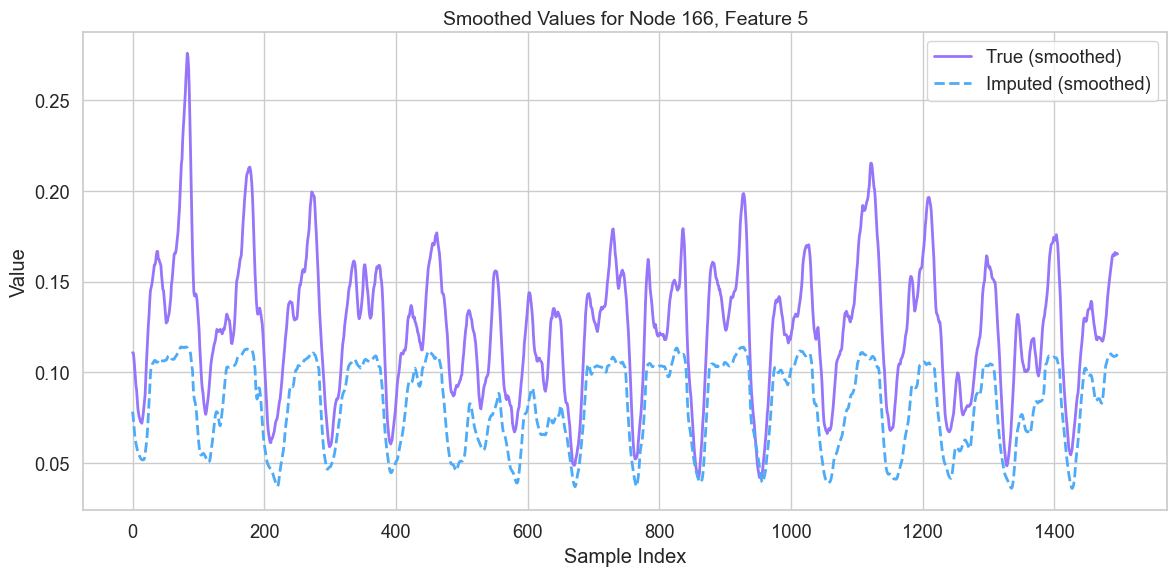

In [22]:
true_vals = results["true_inputs"]      
imputed_vals = results["imputations"]   
# Plot for a specific node and feature
node_idx = 166 # first node
feature_idx = 5   # feature index you want to plot

vis_utils.plot_smoothed_node_series(true_vals, imputed_vals, node_idx=node_idx, feature_idx=feature_idx)


Test for the Forecasting

In [23]:

results = training_utils.run_imputation_inference(
    model=modele,
    X=X_test,
    seq_len=seq_len,
    pred_len=pred_len,
    node_mask=node_mask,
    adj_matrix=adj_matrix,
    batch_size=batch_size,
    device=device,
    loss_fn=loss_fn
)

✅ Imputation Loss: 0.01766


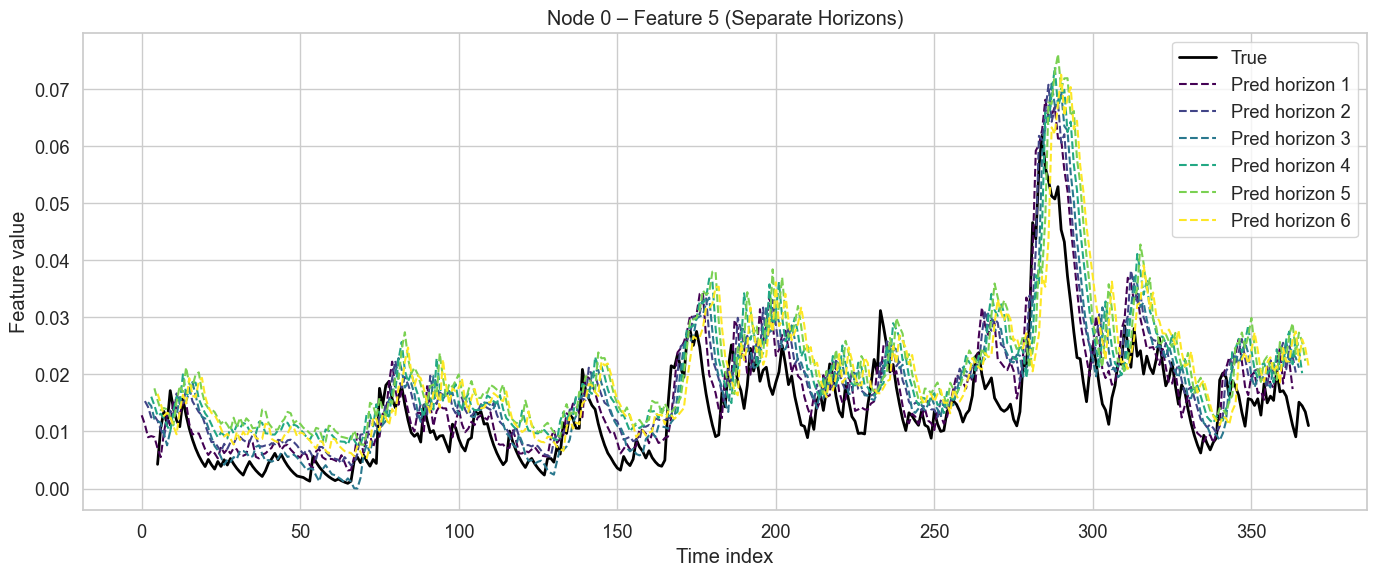

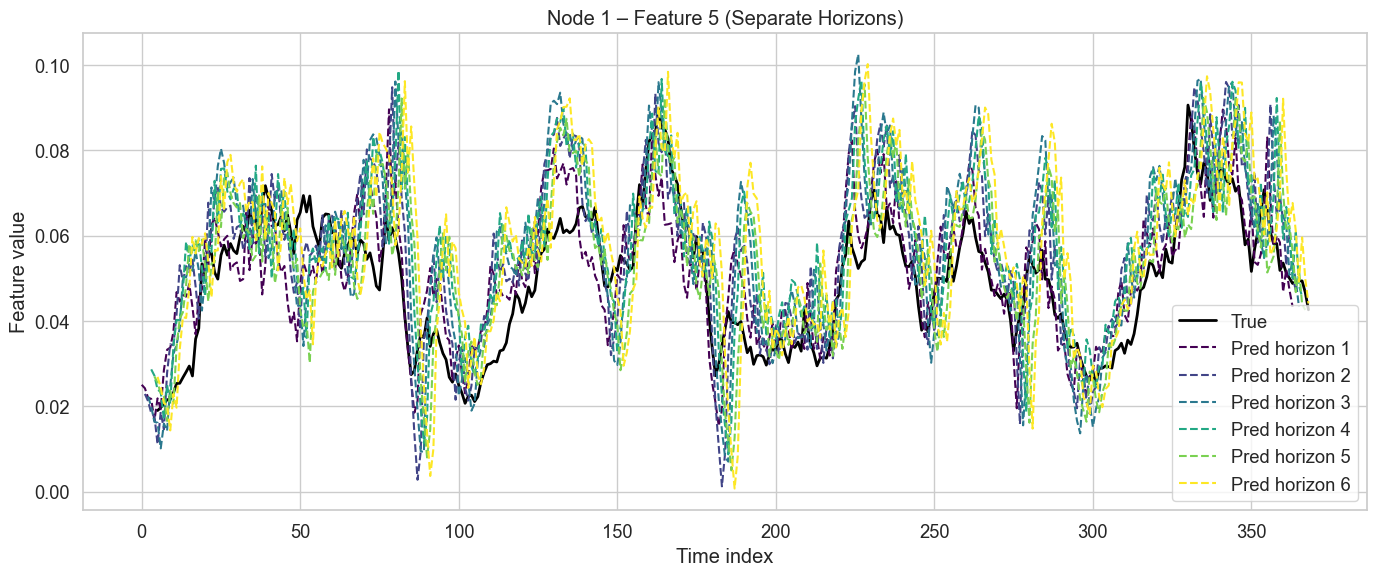

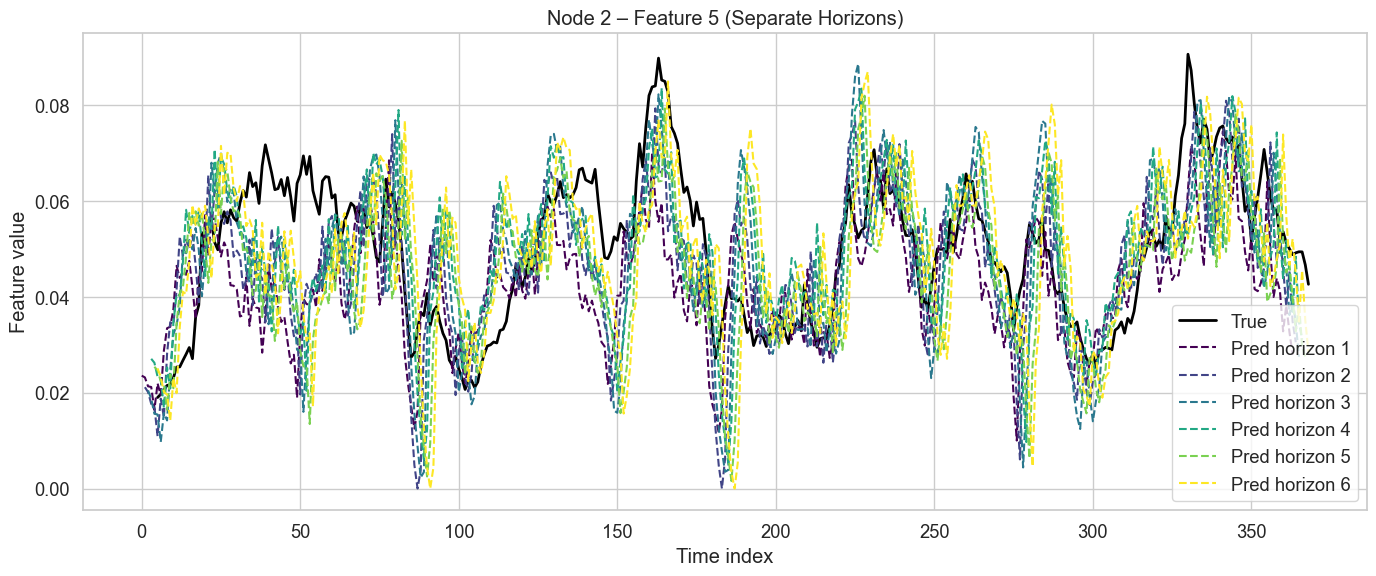

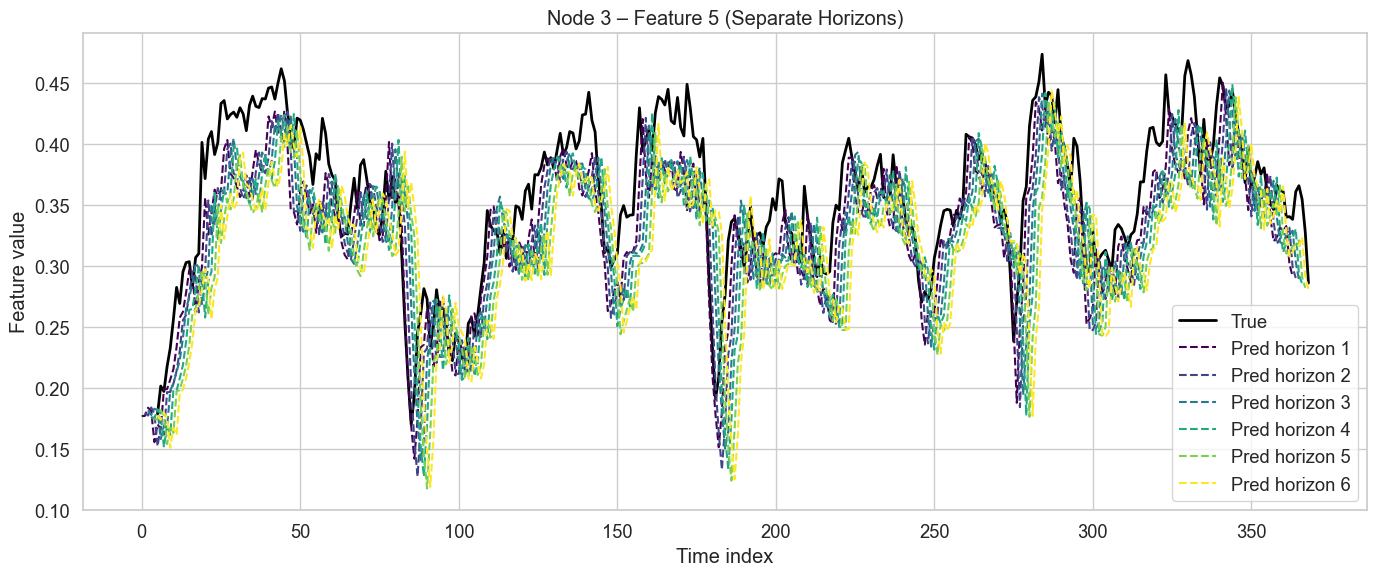

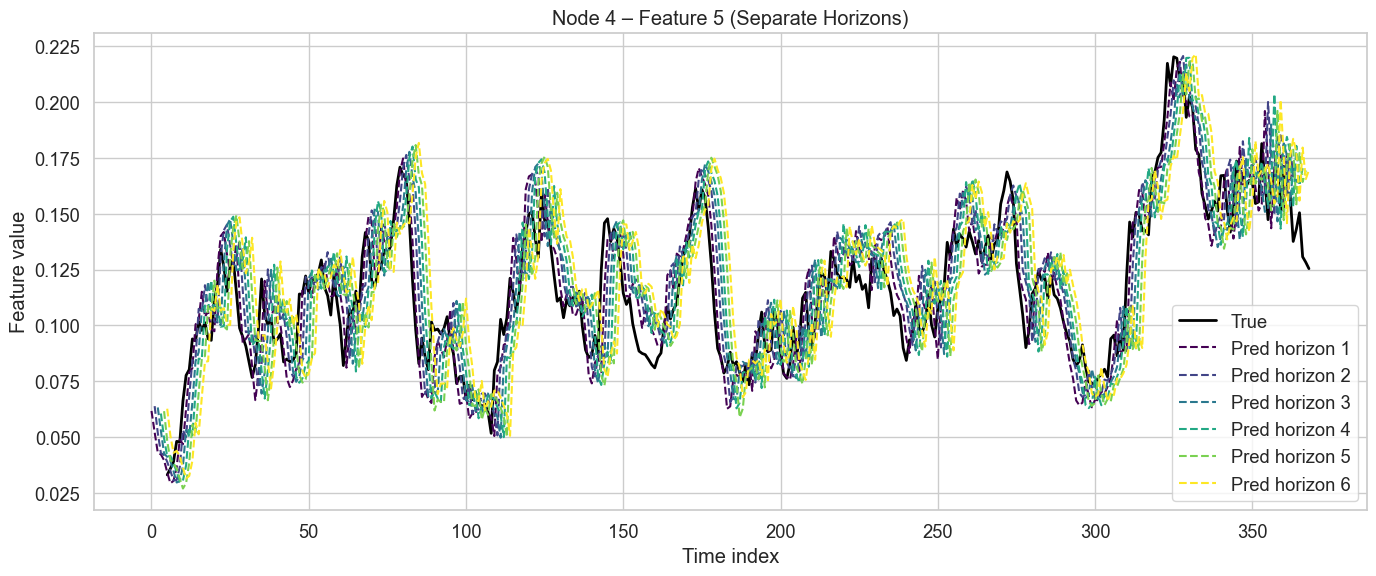

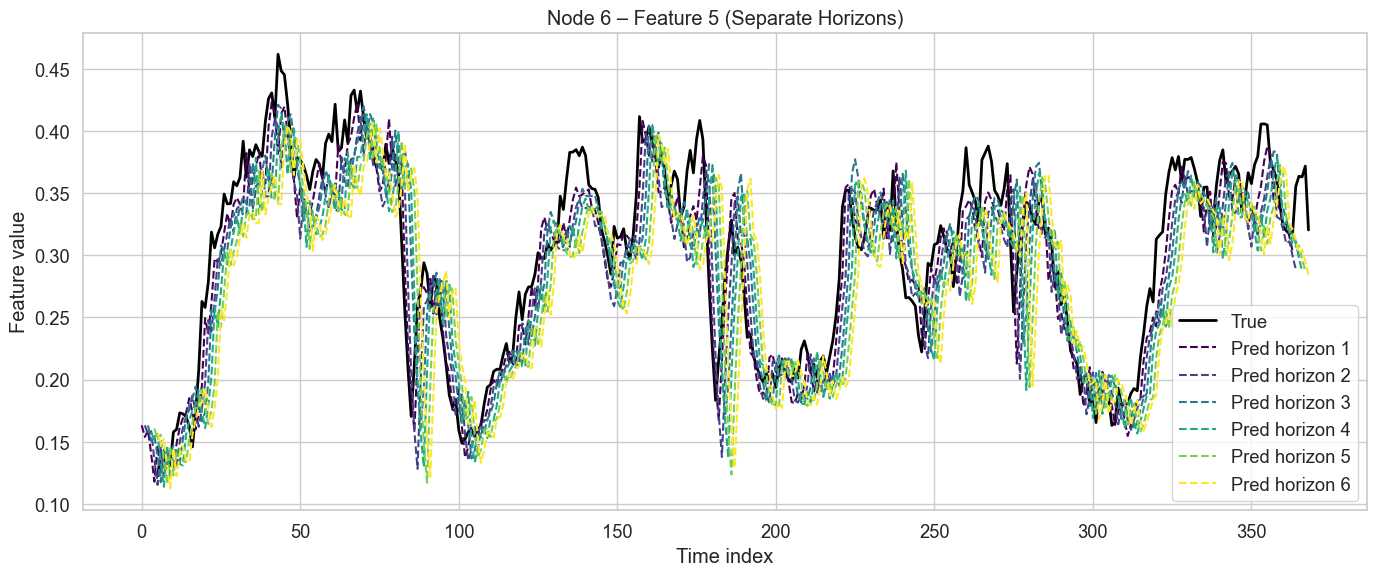

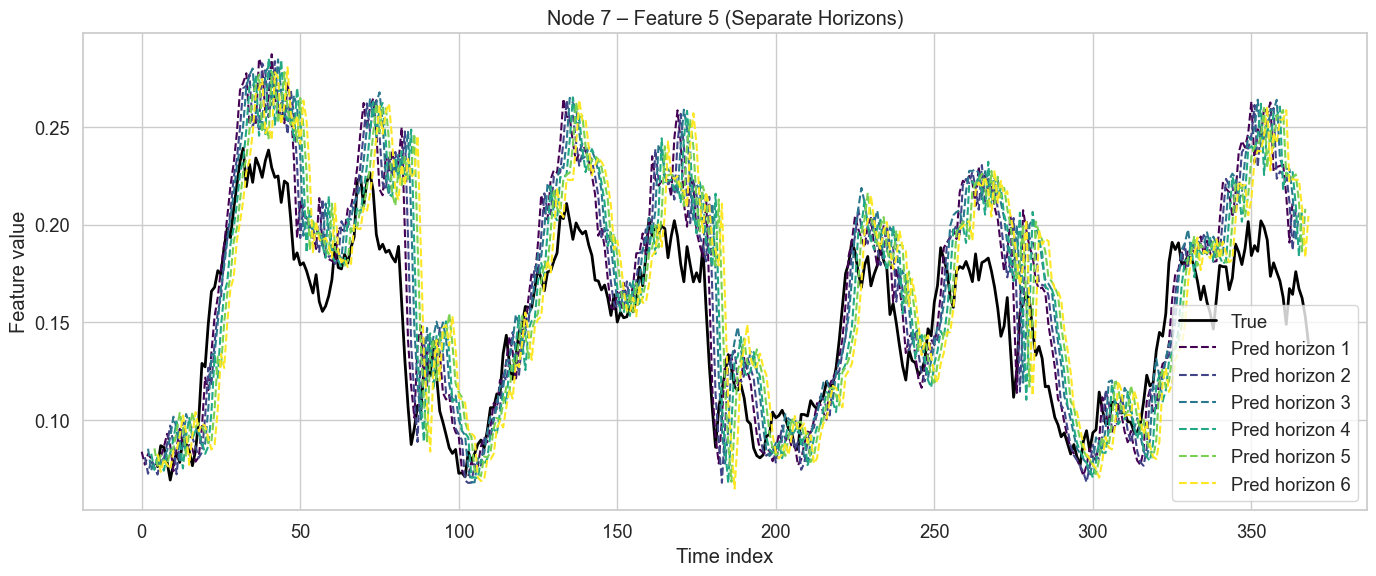

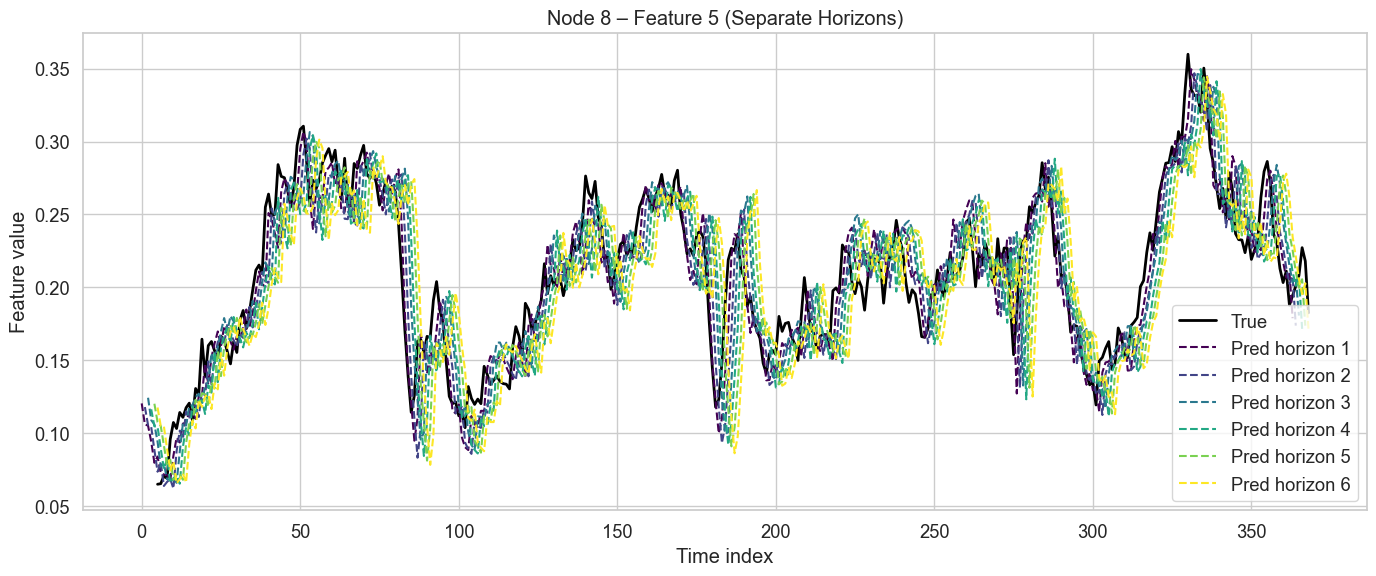

In [24]:
true_forecast = results["true_forecast"]      
predictions = results["predictions"]  
N = X.shape[1]                   
concerned_nodes = [node for node in range(9) if node not in missing_indexes]
vis_utils.plot_node_inference_curves(true_forecast, predictions, concerned_nodes)

Visualizing the predictions on the Map

In [25]:
import numpy as np
emission_idx = 5
pred_emissions = predictions[..., emission_idx]  # shape: (B, T_out, N)
pred_emissions_flat = pred_emissions.reshape(-1, pred_emissions.shape[-1])
print(f"Flattened predictions shape: {pred_emissions_flat.shape}")



Flattened predictions shape: (2184, 189)


In [26]:
import pandas as pd
import folium
from branca.colormap import LinearColormap
import pickle
import networkx as nx
import numpy as np

# ✅ Load road geometry once
with open(r"C:\Users\km_ka\Desktop\Demo\Dataset\Meta_Data\G_custom.pkl", "rb") as f:
    G = pickle.load(f)

road_segments = []
for (u, v) in line_nodes:
    x1, y1 = G.nodes[u]['x'], G.nodes[u]['y']
    x2, y2 = G.nodes[v]['x'], G.nodes[v]['y']
    road_segments.append({
        "edge": (u, v),
        "geometry": [(y1, x1), (y2, x2)]
    })

road_df = pd.DataFrame(road_segments)

# ✅ Function to plot emissions
def plot_emission_map(timestep):
    if timestep < 0 or timestep >= pred_emissions_flat.shape[0]:
        raise ValueError(f"Timestep must be between 0 and {pred_emissions_flat.shape[0]-1}")

    # Get emissions for this timestep
    emissions_t = pred_emissions_flat[timestep]  # shape: (N,)
    cols_to_normalize = ['Sedan Count', 'Vans Count', 'SUV Count', 'Heavy_Truck Count','Total Average Speed (km/h)','Total Emissions (g)']
    # 🔄 Denormalize
    dummy = np.zeros((len(emissions_t), len(cols_to_normalize)))
    emission_col_idx = cols_to_normalize.index("Total Emissions (g)")
    dummy[:, emission_col_idx] = emissions_t
    denorm = scaler.inverse_transform(dummy)
    denorm_emissions = denorm[:, emission_col_idx]

    prediction_df = pd.DataFrame({
        "edge": line_nodes,
        "predicted_emission": denorm_emissions
    })

    merged = road_df.merge(prediction_df, on="edge")
    merged["predicted_emission_kg"] = merged["predicted_emission"] / 1000.0

    # ✅ Fixed color scale: 0 kg = green, 6 kg = red
    colormap = LinearColormap(
        colors=['green', 'yellow', 'red'],
        vmin=0,          # start at 0 kg
        vmax=6           # 6 kg is max → fully red
    )

    # Clip emissions > 6 kg to 6 (so they stay red)
    merged["predicted_emission_kg_clipped"] = merged["predicted_emission_kg"].clip(upper=6)

    # ✅ Create folium map
    m = folium.Map(location=[40.7831, -73.9712], zoom_start=13)
    for _, row in merged.iterrows():
        folium.PolyLine(
            locations=row["geometry"],
            color=colormap(row["predicted_emission_kg_clipped"]),
            weight=4,
            tooltip=f"Edge: {row['edge']} | Emission: {row['predicted_emission_kg']:.3f} kg"
        ).add_to(m)

    colormap.caption = f"Predicted Emissions (kg) — Timestep {timestep+1}/{pred_emissions_flat.shape[0]}"
    colormap.add_to(m)

    return m

In [29]:
from ipywidgets import interact, IntSlider

# ✅ Interactive widget
interact(
    plot_emission_map,
    timestep=IntSlider(
        min=0,
        max=pred_emissions_flat.shape[0] - 1,  # use flattened timeline
        step=1,
        value=0,
        description="Timestep"
    )
)


interactive(children=(IntSlider(value=0, description='Timestep', max=2183), Output()), _dom_classes=('widget-i…

<function __main__.plot_emission_map(timestep)>